In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[class_name])
        
        print(f"Found {len(self.classes)} classes: {self.classes}")
        print(f"Total images: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Step 3: Load and Visualize Data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Single channel normalization
])


dataset = EmotionDataset(root_dir='/kaggle/input/emotion-detection-fer/train', transform=transform)
validation_dataset = EmotionDataset(root_dir='/kaggle/input/emotion-detection-fer/test', transform=transform)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True, num_workers=2)

Found 7 classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Total images: 28709
Found 7 classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Total images: 7178


In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

class EmotionResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pretrained ResNet
        weights = ResNet18_Weights.DEFAULT
        self.resnet = resnet18(weights=weights)
        
        # Convert grayscale to RGB by repeating channel
        self.grayscale_to_rgb = lambda x: x.repeat(1, 3, 1, 1)
        
        # Modify final layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.grayscale_to_rgb(x)
        return self.resnet(x)

In [8]:
model = EmotionResNet(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()

initial_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
total_steps = 1 * len(train_loader)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=total_steps
)

In [9]:
history = {'steps': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
step = 0

def train_epoch(model, train_loader, val_loader, criterion, optimizer, scheduler):
    global step
    model.train()
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        current_lr = scheduler.get_last_lr()[0]
        
        if batch_idx % 10 == 0:
            current_loss = loss.item()
            current_acc = 100. * outputs.max(1)[1].eq(labels).sum().item() / labels.size(0)
            
            # Validation metrics
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_labels).item()
                    val_correct += val_outputs.max(1)[1].eq(val_labels).sum().item()
                    val_total += val_labels.size(0)
            
            val_loss = val_loss / len(val_loader)
            val_acc = 100. * val_correct / val_total
            
            # Log metrics
            history['steps'].append(step)
            history['train_loss'].append(current_loss)
            history['train_acc'].append(current_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['lr'].append(current_lr)
            
            print(f'Step {step} - LR: {current_lr:.6f} | Train Loss: {current_loss:.4f}, Acc: {current_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')
            
            step += 1
            model.train()

In [10]:
train_epoch(model, train_loader, validation_loader, criterion, optimizer, scheduler)

Step 0 - LR: 0.000996 | Train Loss: 2.0270, Acc: 13.28% | Val Loss: 1.9890, Acc: 27.56%
Step 1 - LR: 0.000952 | Train Loss: 1.4224, Acc: 46.09% | Val Loss: 3.1944, Acc: 34.75%
Step 2 - LR: 0.000908 | Train Loss: 1.3165, Acc: 51.56% | Val Loss: 3.3704, Acc: 22.89%
Step 3 - LR: 0.000864 | Train Loss: 1.3285, Acc: 53.91% | Val Loss: 1.4873, Acc: 47.21%
Step 4 - LR: 0.000820 | Train Loss: 1.2626, Acc: 56.25% | Val Loss: 1.6005, Acc: 41.36%
Step 5 - LR: 0.000776 | Train Loss: 1.0405, Acc: 67.19% | Val Loss: 1.2070, Acc: 54.19%
Step 6 - LR: 0.000732 | Train Loss: 1.0633, Acc: 60.94% | Val Loss: 1.3338, Acc: 51.17%
Step 7 - LR: 0.000688 | Train Loss: 1.1946, Acc: 55.47% | Val Loss: 1.2720, Acc: 50.43%
Step 8 - LR: 0.000644 | Train Loss: 1.1759, Acc: 61.72% | Val Loss: 1.2098, Acc: 53.72%
Step 9 - LR: 0.000600 | Train Loss: 1.0348, Acc: 66.41% | Val Loss: 1.1820, Acc: 56.45%
Step 10 - LR: 0.000556 | Train Loss: 1.0290, Acc: 63.28% | Val Loss: 1.1899, Acc: 56.10%
Step 11 - LR: 0.000512 | Train 

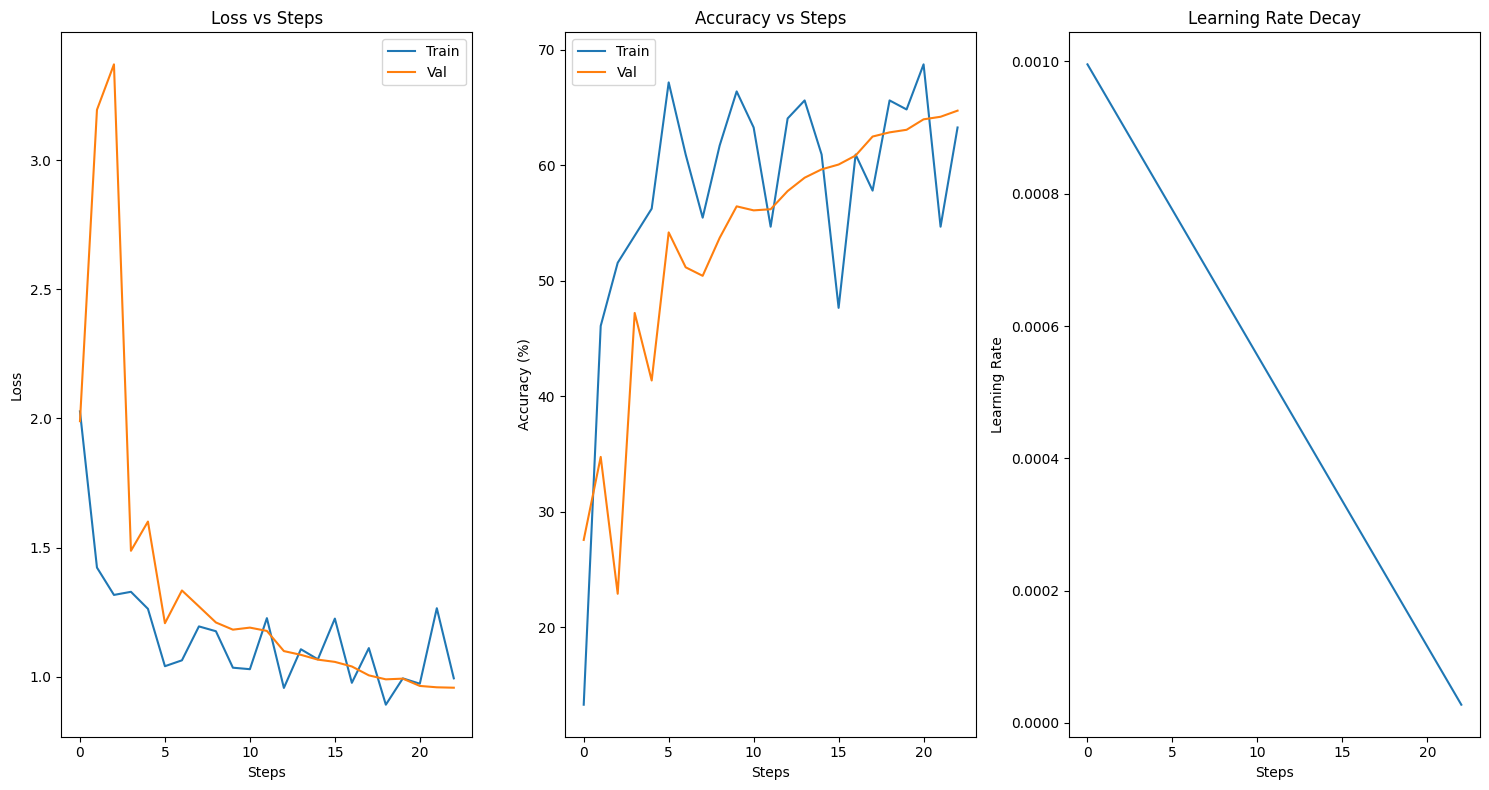

In [11]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.plot(history['steps'], history['train_loss'], label='Train')
plt.plot(history['steps'], history['val_loss'], label='Val')
plt.title('Loss vs Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['steps'], history['train_acc'], label='Train')
plt.plot(history['steps'], history['val_acc'], label='Val')
plt.title('Accuracy vs Steps')
plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['steps'], history['lr'])
plt.title('Learning Rate Decay')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()

In [13]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': 1,
    'history': history
}, 'checkpoint.pth')